# Resume Screening - Applicant Tracking System (ATS)

Henry Yost, Riya Ashok, Angelina Jordan, Gokul Giridharan, and Refugio Zepeda Jr

## Project Outline

[Presentation Link](https://docs.google.com/presentation/d/1MTr2Wf4u3LQDxWHD8F7vfF0gIcAztHeYNlShb_iOBdg/edit?usp=sharing)

This project aims to build an AI-powered resume screening and matching system that streamlines the hiring process through a combination of natural language processing and machine learning techniques. The process begins by using a BERT-based classifier to categorize resumes into broad job categories/buckets, with each category saved as a separate CSV file. Once a specific job description is identified, such as a Software Engineer position at Apple, the most relevant category file is selected for deeper analysis. Resumes are then preprocessed through lowercasing, symbol and indent removal, and text normalization. In the first filtering phase, regular expressions and strict criteria are used to eliminate unqualified resumes. An ideal resume, such as that of the person currently in the role, is selected to serve as a benchmark. TF-IDF vectors are computed for both the ideal and candidate resumes, and cosine similarity is used to rank applicants based on textual closeness. The top 20 resumes are manually reviewed and labeled as qualified or not, creating a dataset for supervised learning. Two classification models are then trained: logistic regression on BERT embeddings to capture semantic meaning, and Naive Bayes on TF-IDF vectors for keyword-based matching. Finally, the outputs of these models are combined using soft voting, rank fusion, or stacking to produce a final ranked list of candidates. This hybrid approach leverages both human insight and machine intelligence to identify the most suitable applicants for a given role.

## Dataset Exploration & Variables in the Dataset
The main dataset that we are using is Resume.csv from Kaggle, and this dataset contains over 2484 resumes, each labeled with a specific job category. The dataset was approved by the professor, as we are doing a unique project.

* **ID** – The ID is the unique identifier for each resume
* **Resume_str** – The content/words of the resume (including formatting)
* **Resume_html** – The contents of the resume in HTML format
* **Category** – The labeled job field for the respective resume (HR, Tech, Finance, Aviation...)

[Dataset Link](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset)

### Plan

1. Classify 24 categories into 5-6 meaningful buckets
3. Save each bucket as a new CSV file
4. Find a Job Description (i.e., Software Engineer @ Apple) and use the most closely related CSV file/dataframe (Tech)
5. Preprocess the resumes (lowercasing, removing symbols, indents, etc) using RegEx and Python functions

**Phase 1:** Basic Filtering
1. Use RegEx and hard criteria to filter resumes
2. Convert resumes and job descriptions to SBERT embeddings and compute the  cosine similarity score.

**Phase 2:** Ideal Resume Comparison
1. Pick multiple IDEAL resumes for the position (let's say the person is leaving, pick multiple ideal resumes for said position)
2. Compute the average embedding and compare new resumes to the centroid of the ideal cluster

**Phase 3:** Human Labeling & Supervised Training
1. A human looks through the top resumes and marks them as qualified or not
2. Train the logistical regression on top resumes and average ideal embeddings with labels
3. Naive Bayes with TF-IDF
4. Combine via soft voting, rank fusion, or stacking (not sure which one would work best)

## Libraries
For this project, we are using a handful of specific libraries. Please make sure you already have them installed in your conda environment, or run the 'pip install'.

* Pandas, Numpy, 
* Re
* SentenceTransformer
* Numpy

In [7]:
# Installing additional libraries
!pip install -U -q sentence-transformers
!pip install -q wordcloud

In [8]:
# Library Importing
import pandas as pd
import re #RegEx

# First stage resume cleaning
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import math as math

## 1. Importing Dataset & Cleaning

In [10]:
df_orig = pd.read_csv("Resume.csv")
df_orig = df_orig.drop("Resume_html", axis=1) # Drop HTML, because we do not need it

# All possible categories: HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, 
# Healthcare, Fitness, Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, 
# Finance, Apparel, Engineering, Accountant, Construction, Public Relations, Banking, Arts, Aviation

# Separate into approx 5 meaningful buckets
df_tech = df_orig[df_orig['Category'].isin(['INFORMATION-TECHNOLOGY', 'ENGINEERING', 'DIGITAL-MEDIA', 'HR'])]
df_tech = df_tech.copy()

df_health_well = df_orig[df_orig['Category'].isin(['HEALTHCARE', 'FITNESS'])]
df_health_well = df_health_well.copy()

df_bus_fin = df_orig[df_orig['Category'].isin(['BUSINESS-DEVELOPMENT', 'SALES', 'CONSULTANT', 'FINANCE', 'ACCOUNTANT', 'BANKING'])]
df_bus_fin = df_bus_fin.copy()

df_creative_public = df_orig[df_orig['Category'].isin(['ARTS', 'DESIGNER', 'PUBLIC-RELATIONS', 'TEACHER', 'ADVOCATE'])]
df_creative_public = df_creative_public.copy()

df_indust = df_orig[df_orig['Category'].isin(['AGRICULTURE', 'AUTOMOBILE', 'CONSTRUCTION', 'AVIATION', 'BPO'])]
df_indust = df_indust.copy()

df_misc = df_orig[df_orig['Category'].isin(['CHEF', 'APPAREL'])]
df_misc = df_misc.copy()

# Write each bucket to a CSV
df_tech.to_csv("tech.csv")
df_health_well.to_csv("health_wellness.csv")
df_bus_fin.to_csv("business_finance.csv")
df_creative_public.to_csv("creative_public.csv")
df_indust.to_csv("industrial.csv")
df_misc.to_csv("miscellaneous.csv")

In [11]:
# Using RegEx to clean the Resume strings
def clean_resume(text):
    text = text.lower() # Make everything lowercase.
    text = re.sub(r'\s+', ' ', text) # replaces whitespace characters with a single space.
    text = re.sub(r'\/+', ' ', text) # replaces / characters with a single space (some resumes use backslashes)
    text = re.sub(r'[^a-z0-9\s\.\,\-]', '', text) # keeps letters, numbers, whitespace, periods, and dashes.
    text = re.sub(r'\s+', ' ', text).strip() # replaces leading and trailing whitespace characters.
    return text

df_tech.loc[:, "Cleaned_str"] = df_tech["Resume_str"].apply(clean_resume)
df_health_well.loc[:, "Cleaned_str"] = df_health_well["Resume_str"].apply(clean_resume)
df_bus_fin.loc[:, "Cleaned_str"] = df_bus_fin["Resume_str"].apply(clean_resume)
df_creative_public.loc[:, "Cleaned_str"] = df_creative_public["Resume_str"].apply(clean_resume)
df_indust.loc[:, "Cleaned_str"] = df_indust["Resume_str"].apply(clean_resume)
df_misc.loc[:, "Cleaned_str"] = df_misc["Resume_str"].apply(clean_resume)

# Also, there are no NaN values, so we don't need to drop any rows.

df_tech.head()

,ID,Resume_str,Category,Cleaned_str
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,"hr specialist, us hr operations summary versat..."
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary over 20 years experience i...
3,27018550,HR SPECIALIST Summary Dedica...,HR,"hr specialist summary dedicated, driven, and d..."
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...


## 4. Exploratory Data Analysis (EDA)

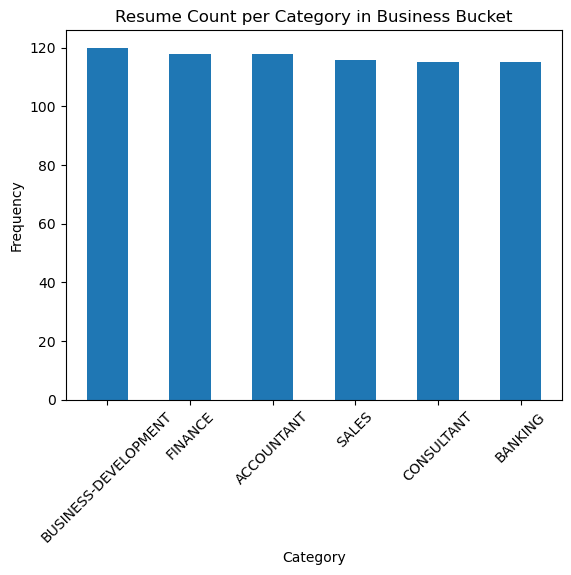

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

bus_count = df_bus_fin['Category'].value_counts()
bus_count.plot(kind='bar')

plt.title("Resume Count per Category in Business Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

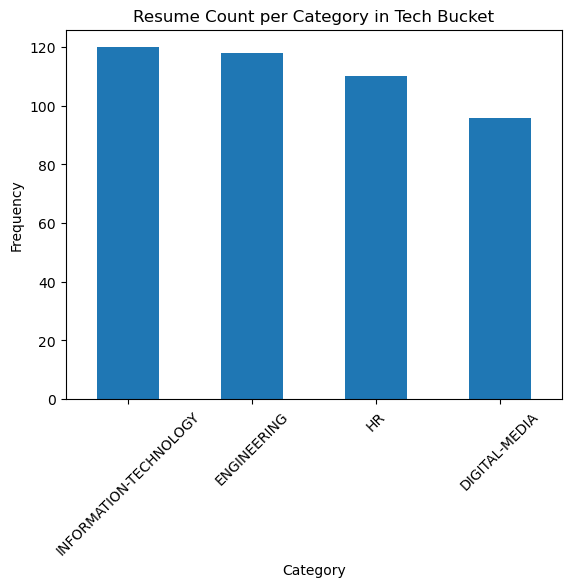

In [14]:
tech_count = df_tech['Category'].value_counts()
tech_count.plot(kind='bar')
plt.title("Resume Count per Category in Tech Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

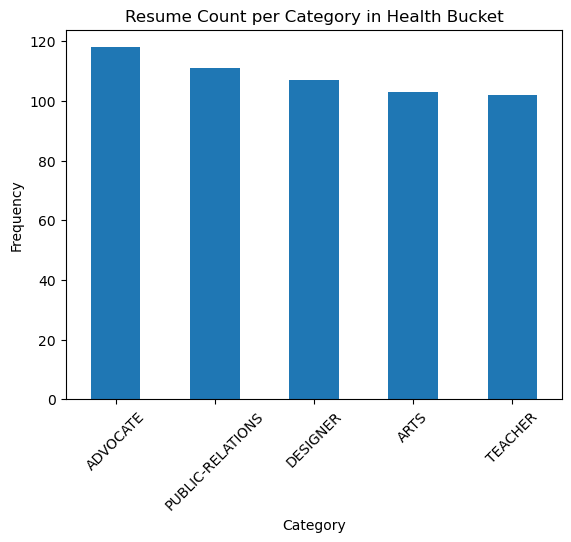

In [15]:
creative_count = df_creative_public['Category'].value_counts()
creative_count.plot(kind='bar')
plt.title("Resume Count per Category in Health Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

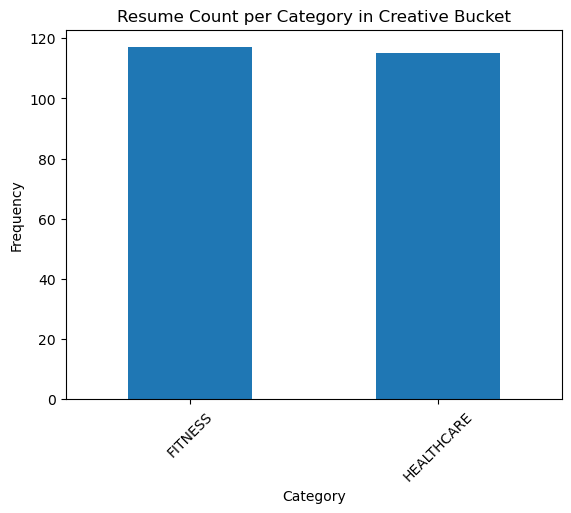

In [16]:
health_count = df_health_well['Category'].value_counts()
health_count.plot(kind='bar')
plt.title("Resume Count per Category in Creative Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

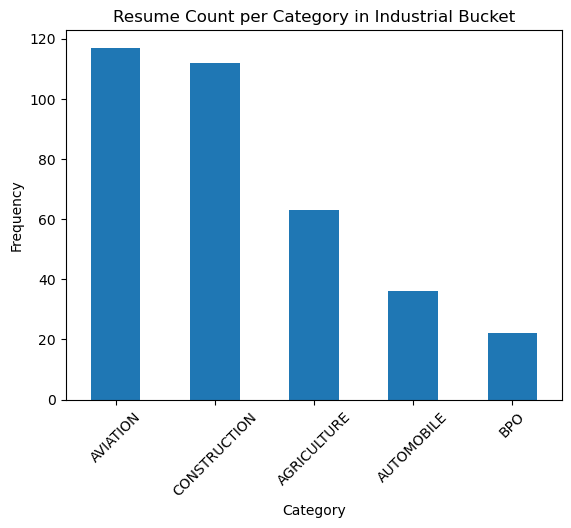

In [17]:
industrial_count = df_indust['Category'].value_counts()
industrial_count.plot(kind='bar')
plt.title("Resume Count per Category in Industrial Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

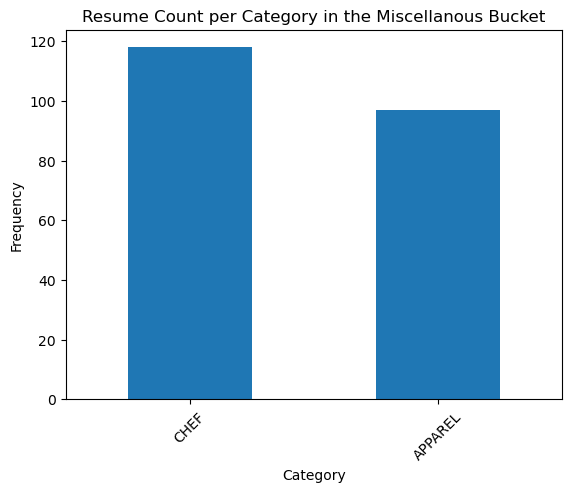

In [18]:
industrial_count = df_misc['Category'].value_counts()
industrial_count.plot(kind='bar')
plt.title("Resume Count per Category in the Miscellanous Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')
Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')
Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')


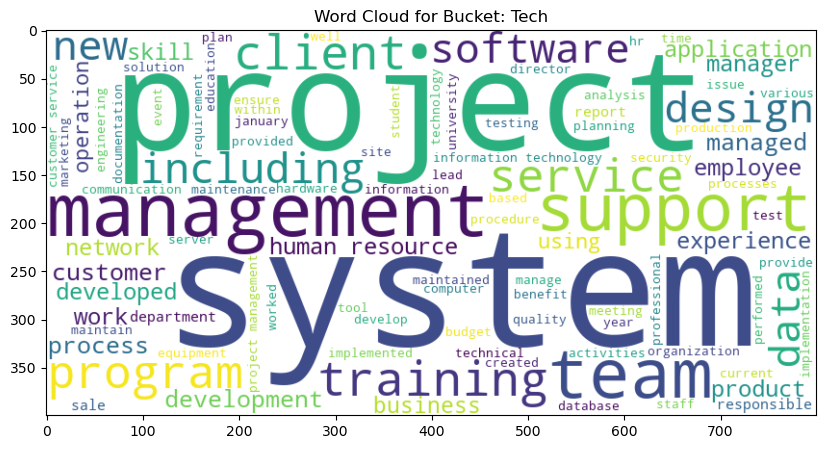

In [19]:
from collections import Counter
print(df_tech.columns)
print(df_bus_fin.columns)
print(df_health_well.columns)

texts = ' '.join(df_tech["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Tech")
plt.show()

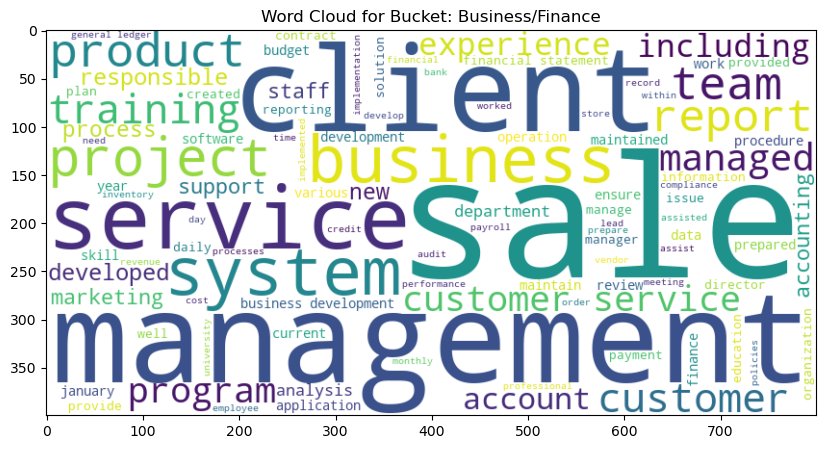

In [20]:
texts = ' '.join(df_bus_fin["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'City'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Business/Finance")
plt.show()

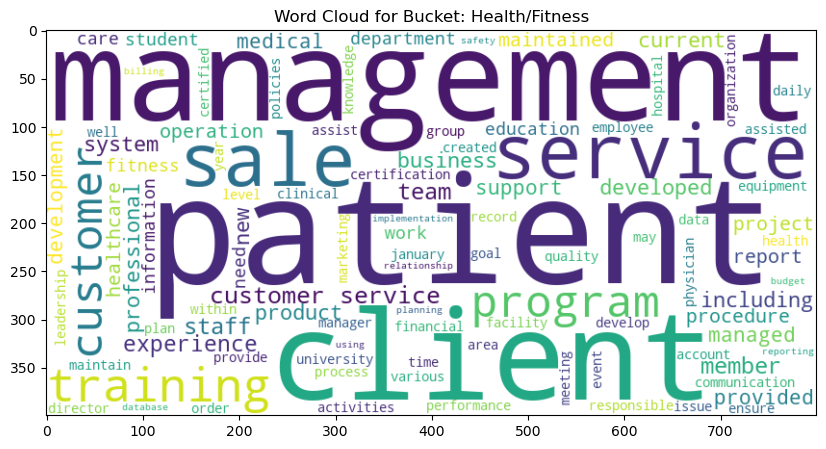

In [21]:
texts = ' '.join(df_health_well["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'skills'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Health/Fitness")
plt.show()

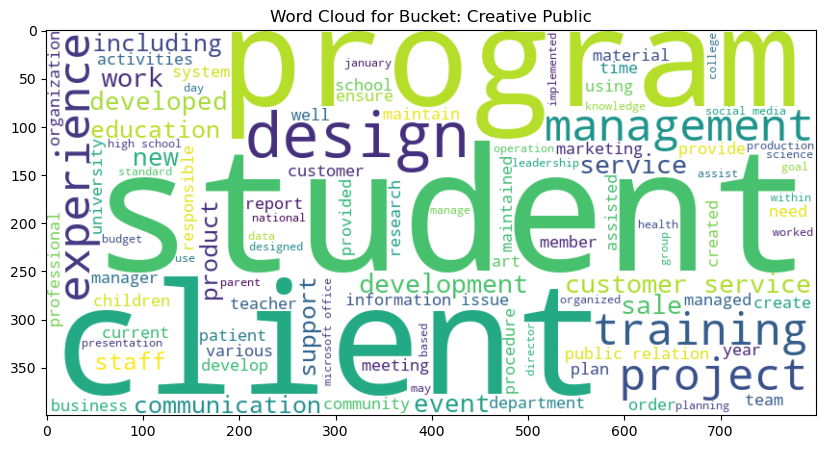

In [22]:
texts = ' '.join(df_creative_public["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'skills'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Creative Public")
plt.show()

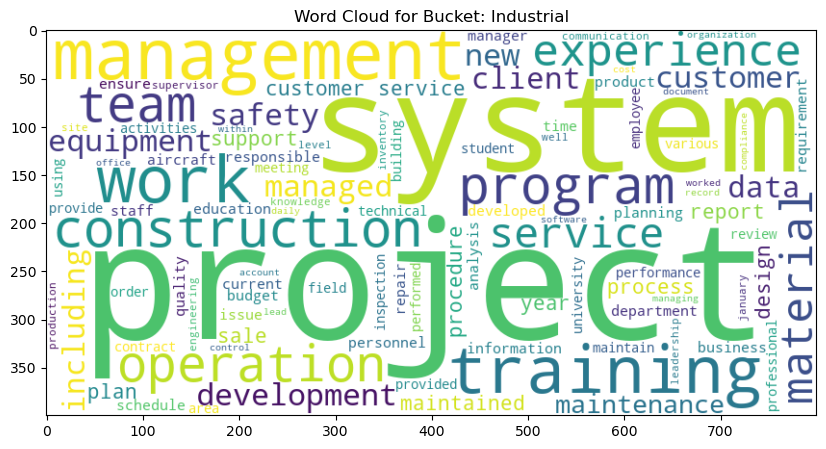

In [23]:
texts = ' '.join(df_indust["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'skills'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Industrial")
plt.show()

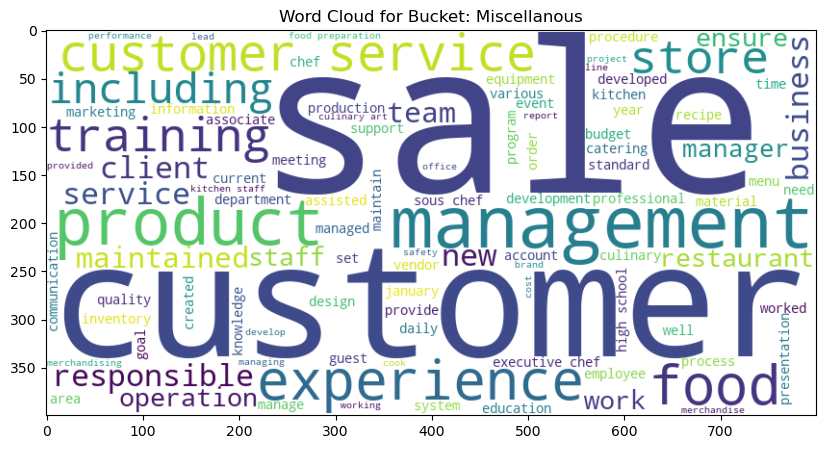

In [24]:
texts = ' '.join(df_misc["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'skills'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Miscellanous")
plt.show()

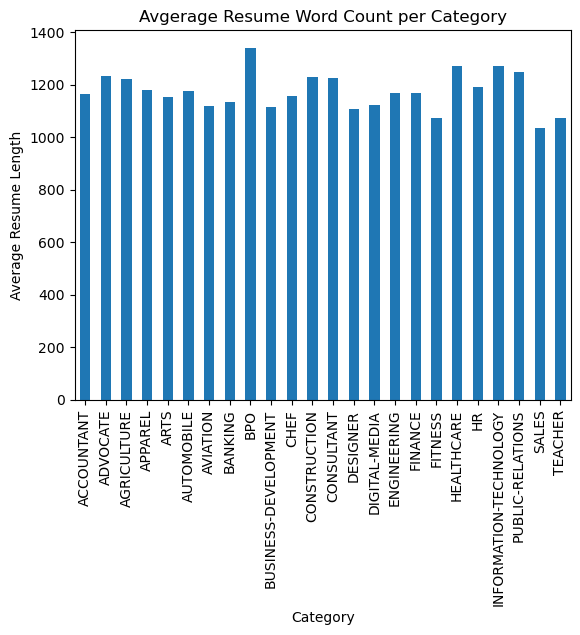

In [25]:
df_orig['resume_length'] = df_orig['Resume_str'].str.count(' ').add(1)
average_length = df_orig.groupby('Category')['resume_length'].mean()

average_length.plot(kind='bar')
plt.title("Average Resume Word Count per Category")
plt.xlabel("Category")
plt.ylabel("Average Resume Length")
plt.xticks(rotation=90)
plt.show()

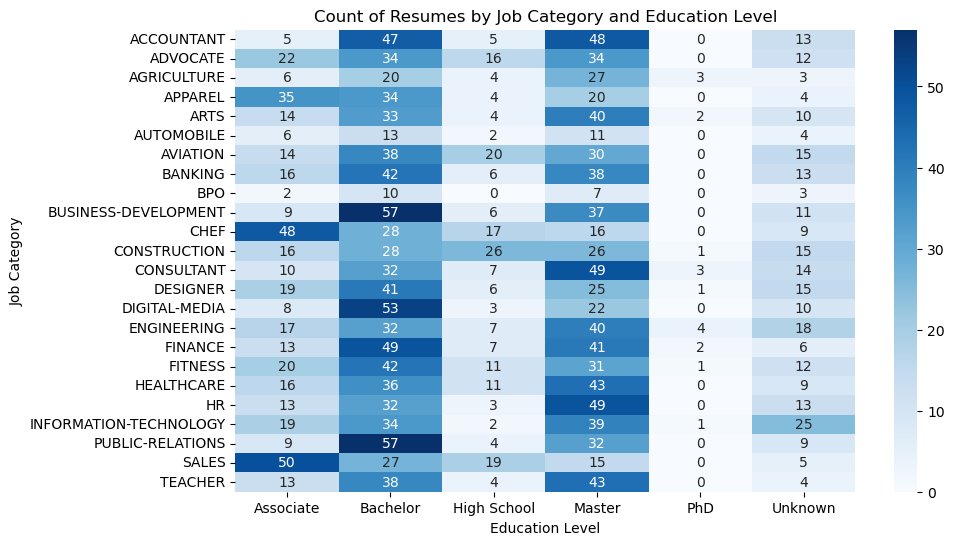

In [26]:
#library
education_levels = {
    'PhD': ['phd', 'doctor of philosophy'],
    'Master': ['master', 'masters', 'msc', 'mba'],
    'Bachelor': ['bachelor', 'bachelors', 'bsc', 'ba'],
    'Associate': ['associate', 'associates'],
    'High School': ['high school', 'ged']
}


def extract_education_level(texts):
    texts = texts.lower()
    for level, keywords in education_levels.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', texts):
                return level
    return 'Unknown'

#Apply the function onto resume string to create a new row 
df_orig['education_level'] = df_orig['Resume_str'].apply(extract_education_level)

import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = pd.crosstab(df_orig['Category'], df_orig['education_level'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
plt.title('Count of Resumes by Job Category and Education Level')
plt.ylabel('Job Category')
plt.xlabel('Education Level')
plt.show()

# Tesla Software and Energy Engineer
## 1. First Resume Cleaning Cycle

In [28]:
# Extracting related fields from job description

# Move to file potentially
# https://www.linkedin.com/jobs/view/4239183377
tesla_job_desc = (
    "Develop, enhance and debug new and existing real-time software in C/C++ in embedded RTOS environments. "
    "Work with HW and system teams on building testing infrastructure. Help design and bring up state of the art HIL/SIL validation infrastructure. "
    "Help implement software tests for HIL/SIL infrastructure. Assist in tool development for testing and system integration. "
    "Own implementation of software/firmware features end to end. What You'll Bring "
    "Pursuing a Degree in Computer Science, Electrical Engineering, Physics or related field. "
    "Desired to have strong understanding of Python debug simple circuits. "
    "Desired to have good electrical and electronics fundamentals to be able to understand schematics and desired to have test driven development mindset. "
    "Remain engaged, proactive and positive while solving very challenging problems. "
    "Own assignments and take full accountability for overall team success. "
    "Capable of delivering top quality C/C++ code for embedded systems."
)

# Grab fields using regex and the tagline "Pursuing a Degree in...". The RegEx captures everything up to the period and groups it into Group 1.
degree_requirements = re.search(r"Pursuing a Degree in (.+?)(?:\.|$)", tesla_job_desc, re.IGNORECASE)

# We assume (because we are picking the Job Descriptions) that they all have some form of requirements
# Thus, now we can compare each resume in the dataframe and check if they are pursuing a degree in the xyz field.

# Split on commas, and's or or's
degree_fields = re.split(r',\s*| and | or ', degree_requirements.group(1))

# More processing on the actual degrees
degree_fields = [i.strip().lower() for i in degree_fields]
degree_fields.remove("related field")

print("Extracted fields:", degree_fields)

Extracted fields: ['computer science', 'electrical engineering', 'physics']


In [29]:
# Additionally, we need to remove the 'related fields' tag in the split and also replace it with potential related fields
related_fields = ['software engineering', 'computer engineering', 'mechanical engineering', 'data science', 'robotics', 'information technology', 'applied physics']
degree_fields = degree_fields + related_fields
print("Extracted fields:", degree_fields)

Extracted fields: ['computer science', 'electrical engineering', 'physics', 'software engineering', 'computer engineering', 'mechanical engineering', 'data science', 'robotics', 'information technology', 'applied physics']


In [30]:
# Now we check if the actual resumes have any variation of these fields in them
def resume_degree_matching(resume):
    for degree in degree_fields:
        if degree in resume:
            return True
    return False

df_tech['matching_degree'] = df_tech['Cleaned_str'].apply(resume_degree_matching)
df_tech_match = df_tech[df_tech['matching_degree'] == True].copy()

In [31]:
# Load a pre-trained SBERT model (https://sbert.net/)
m_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

tesla_job_embeddings = m_SBERT.encode(tesla_job_desc)

def compute_similarity(resume):
    resume_embeddings = m_SBERT.encode(resume)
    similarity = cosine_similarity([resume_embeddings], [tesla_job_embeddings])[0][0]
    return similarity

df_tech_match['Computed_similarity'] = df_tech_match['Cleaned_str'].apply(compute_similarity)

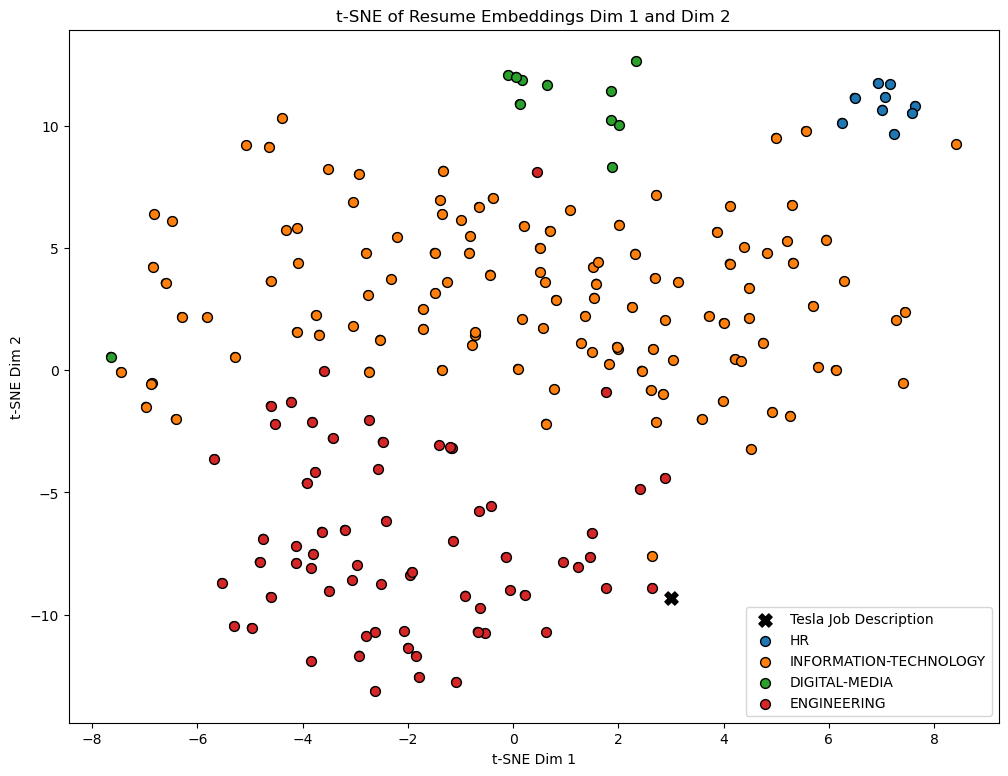

In [35]:
# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

resume_embeddings = df_tech_match['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
resume_embeddings = np.vstack(resume_embeddings)
all_embeddings = np.vstack([resume_embeddings, tesla_job_embeddings])

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = all_embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(all_embeddings)

df_tnse_fitted = pd.DataFrame()

# Add ID and cosine similarity
df_tnse_fitted['Category'] = df_tech_match['Category']
categories = df_tnse_fitted['Category'].astype('category')
color_codes = categories.cat.codes

df_tnse_fitted['X'] = tnse_fitted[:-1,0]
df_tnse_fitted['Y'] = tnse_fitted[:-1,1]

# Job description
x_job = tnse_fitted[-1, 0]
y_job = tnse_fitted[-1, 1]

# Plot everything
plt.figure(figsize=(12, 9))
scatter = plt.scatter(df_tnse_fitted['X'], df_tnse_fitted['Y'], c = color_codes, edgecolors='black')
plt.scatter(x_job, y_job, color='black', marker='X', s=90, label='Tesla Job Description')

# I had to use ChatGPT for this part because honestly, I have no idea how to do this and couldn't find a way
unique_categories = df_tnse_fitted['Category'].unique()
colors = plt.cm.tab10.colors

# Loop through each category to plot them one by one
for idx, category in enumerate(unique_categories):
    subset = df_tnse_fitted[df_tnse_fitted['Category'] == category]
    plt.scatter(
        subset['X'], subset['Y'],
        color=colors[idx % len(colors)],
        edgecolors='black',
        label=category,
        s=50
    )
# Till this part

# Axis labels and title
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Resume Embeddings Dim 1 and Dim 2")
plt.legend()
plt.show()

In [ ]:
# If over a similarity threshold, print index and similarity.
df_tech_cleaned = df_tech_match[df_tech_match['Computed_similarity'] >= 0.45].copy()
df_tech_cleaned.head()

In [ ]:
# Prob going to delete this one, because it doesn't really make sense. TBH I just thought it looked cool but
# it doesn't help much and took way too long

# Graphing resume embeddings with computed similarity
# https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

resume_embeddings = df_tech_cleaned['Cleaned_str'].apply(lambda x: m_SBERT.encode(x))
resume_embeddings = np.vstack(resume_embeddings)
all_embeddings = np.vstack([resume_embeddings, tesla_job_embeddings])

# Perplexity is too high, so update it to a number between 5 and 30 based on neighbors
n_samples = embeddings.shape[0]
l_perplexity = min(30, max(2, math.floor(n_samples / 3)))

tsne = TSNE(random_state = 0, max_iter = 1000, metric = 'cosine', perplexity = l_perplexity)
tnse_fitted = tsne.fit_transform(all_embeddings)

df_tnse_fitted = pd.DataFrame()

# Add ID and cosine similarity
df_tnse_fitted['ID'] = df_tech_cleaned['ID']
df_tnse_fitted['Similarity'] = df_tech_cleaned['Computed_similarity']
df_tnse_fitted['X'] = tnse_fitted[:-1,0]
df_tnse_fitted['Y'] = tnse_fitted[:-1,1]

# Job description
x_job = tnse_fitted[-1, 0]
y_job = tnse_fitted[-1, 1]

# Plot everything
plt.figure(figsize=(12, 9))
scatter = plt.scatter(df_tnse_fitted['X'], df_tnse_fitted['Y'], c = df_tnse_fitted['Similarity'], cmap='autumn', edgecolors='black')
plt.scatter(x_job, y_job, color='black', marker='X', s=90, label='Job Description')

# Plot ID so that we can see what resume it is
for i, j in df_tnse_fitted.iterrows():
    plt.text(j['X'] - 3, j['Y'] + 2, j['ID'], size = 8)

# Axis labels and title
bar = plt.colorbar(scatter)
bar.set_label("Cosine Similarity")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Resume Embeddings Dim 1 and Dim 2")
plt.legend()
plt.show()

In [ ]:
df_tnse_fitted.head()

**t-SNE Visualization of Resume Embeddings and Job Description:** 
This graph is a visual representation of the flattened SBERT embeddings of the closest resumes in terms of similarity. In addition to the SBERT embeddings of the Job description (marked by an `X`). Each dot is colored based on the relationship of the cosine similarity to the job description (Red being a higher similarity score, and blue being a lower similarity score). Additionally, the position of the resumes is based on their embeddings, thus the closer to the job description, means the two are semantically more similar. Thus, points clustered around eachother mean they have greater semantic similarity.

In [ ]:
# Add analysis here

## 2. Second Resume Cleaning Cycle

In [ ]:
# Using TF-IDF and cosine similarity to rank the resumes based on the ideal resume 

## 3. Third Resume Cleaning Cycle & SVM Training

In [ ]:
# Train SVM on synthetic lables